
# IFN580 – Assignment 1: Starter Notebook


## Task 1

In [1]:
# 1.1) Config & Imports
RANDOM_STATE = 42
TARGET_COL = "IsBadBuy"  # change if your target column differs
!pip install imblearn

import os, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Ensure inline plots in classic Notebook
%matplotlib inline

In [2]:
# 1.2) Load Data (robust search + sentinel handling)
DATA_PATHS = [
    "data/kick.csv",
    "kick.csv",
    "assignment 1 data kick.csv",
    "./data/kick.csv",
]

def find_data(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

DATA_PATH = find_data(DATA_PATHS)
if DATA_PATH is None:
    raise FileNotFoundError("CSV not found. Put your dataset as 'data/kick.csv' or update DATA_PATHS.")

print(f"Using data at: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Turn '?' into NaN so imputers treat them as missing
df.replace('?', np.nan, inplace=True)

print(df.shape)
display(df.head(3))

Using data at: data/kick.csv
(41476, 31)


,PurchaseID,PurchaseTimestamp,PurchaseDate,Auction,VehYear,Make,Color,Transmission,WheelTypeID,WheelType,...,MMRCurrentRetailCleanPrice,MMRCurrentRetailRatio,PRIMEUNIT,AUCGUART,VNST,VehBCost,IsOnlineSale,WarrantyCost,ForSale,IsBadBuy
0,0,1253232000,18/09/2009 10:00,OTHER,2008.0,DODGE,RED,AUTO,2,Covers,...,12505,0.941783287,NaN,NaN,NC,7800,0.0,920.0,Yes,0
1,1,1253232000,18/09/2009 10:00,OTHER,2008.0,DODGE,RED,AUTO,2,Covers,...,10571,0.922618485,NaN,NaN,NC,7800,0.0,834.0,Yes,0
2,2,1253232000,18/09/2009 10:00,OTHER,2008.0,CHRYSLER,SILVER,AUTO,2,Covers,...,9932,0.935159082,NaN,NaN,NC,7800,0.0,834.0,Yes,0


In [3]:
# 1.3) Quick Audit + numeric coercion (promote numeric-like object columns)

# Convert object columns that look numeric into real numbers (heuristic)
coerced = []
for c in df.columns:
    if c == TARGET_COL:  # don't touch the target
        continue
    s = pd.to_numeric(df[c], errors="coerce")
    # treat as numeric if majority converts and at least some support
    if (s.notna().mean() > 0.6) and (s.notna().sum() > 100):
        df[c] = s
        coerced.append(c)
print("Coerced to numeric:", len(coerced), "| sample:", coerced[:8])

# Basic info for Task 1 evidence
display(df.info())
print("Target counts (before):")
display(df[TARGET_COL].value_counts(dropna=False))
print("Target ratio (before):")
display(df[TARGET_COL].value_counts(normalize=True))

Coerced to numeric: 17 | sample: ['PurchaseID', 'PurchaseTimestamp', 'VehYear', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41426 non-null  object 
 7   Transmission                       41426 non-null  object 
 8   WheelTypeID                      

None

Target counts (before):


IsBadBuy
0    36105
1     5371
Name: count, dtype: int64

Target ratio (before):


IsBadBuy
0    0.870503
1    0.129497
Name: proportion, dtype: float64

In [4]:
# 1.4) Train/Test Split (stratified) and drop non-predictive columns
drop_cols = [c for c in ["PurchaseID", "PurchaseDate"] if c in df.columns]  # keep PurchaseTimestamp

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL] + drop_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (33180, 28) (8296, 28)


In [5]:
# 1.5) Preprocessing Pipeline (ColumnTransformer) – sklearn-version safe

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.columns.difference(numeric_features).tolist()

# Numeric: impute median then standardize (dense)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: impute mode then One-Hot Encode
# Guard for sklearn param rename: 'sparse' (old) -> 'sparse_output' (new)
try:
    _ = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 16
Categorical features: 12


## Task2

In [6]:
#1a

# Instantiate the model
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Create a pipeline that first preprocesses the data and then trains the model
dt_pipeline = Pipeline(steps=[('preprocessor', preprocess),
                              ('classifier', dt_model)])

# Train the pipeline
dt_pipeline.fit(X_train, y_train)

# Access the parameters of the trained Decision Tree model from the pipeline
dt_params = dt_pipeline.named_steps['classifier'].get_params()

# Display the parameters
print("Decision Tree Model Parameters:")
for param, value in dt_params.items():
    print(f"{param}: {value}")

Decision Tree Model Parameters:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 42
splitter: best


In [7]:
#1bParameters used for the train/test split
test_size = 0.2
random_state = RANDOM_STATE # From the initial config cell
stratify = y # The target variable

print(f"Test set size: {test_size}")
print(f"Random state: {random_state}")
print(f"Stratification used: {stratify.name}")

Test set size: 0.2
Random state: 42
Stratification used: IsBadBuy


In [8]:
#1c
from sklearn.metrics import accuracy_score

# Predict on the training data
y_train_pred = dt_pipeline.predict(X_train)

# Calculate training accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")

# Predict on the test data
y_test_pred = dt_pipeline.predict(X_test)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9998
Test Accuracy: 0.7901


In [9]:
#1e Get the trained Decision Tree model from the pipeline
tree_model = dt_pipeline.named_steps['classifier']

# Get the feature names after preprocessing
preprocessor = dt_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Get the feature index for the root node (first split)
first_split_feature_index = tree_model.tree_.feature[0]
first_split_feature_name = feature_names[first_split_feature_index]

print(f"The variable used for the first split is: {first_split_feature_name}")
print("\nVariables used for splits at the second level:")

# Get the children of the root node (nodes at the second level)
root_node_left_child = tree_model.tree_.children_left[0]
root_node_right_child = tree_model.tree_.children_right[0]

second_level_nodes = []
if root_node_left_child != -1:
    second_level_nodes.append(root_node_left_child)
if root_node_right_child != -1:
    second_level_nodes.append(root_node_right_child)


for node_index in second_level_nodes:
    # Check if the node is a split node (not a leaf node)
    if tree_model.tree_.children_left[node_index] != -1 or tree_model.tree_.children_right[node_index] != -1:
        feature_index = tree_model.tree_.feature[node_index]
        feature_name = feature_names[feature_index]
        print(f"- Node {node_index}: {feature_name}")
    else:
        print(f"- Node {node_index}: (This is a leaf node, no split)")

The variable used for the first split is: VehYear

Variables used for splits at the second level:
- Node 1: VehBCost
- Node 3128: WheelType_Alloy


In [10]:
#1d Get the number of nodes
n_nodes = tree_model.tree_.node_count

# Get the number of rules (leaf nodes)
# A node is a leaf node if its left and right children are both -1
leaf_nodes = tree_model.tree_.children_left == tree_model.tree_.children_right
n_rules = np.sum(leaf_nodes)

print(f"Number of nodes in the Decision Tree: {n_nodes}")
print(f"Number of rules (leaf nodes) in the Decision Tree: {n_rules}")

Number of nodes in the Decision Tree: 8059
Number of rules (leaf nodes) in the Decision Tree: 4030


In [11]:
#1fGet the feature importances
importances = tree_model.feature_importances_

# Create a pandas Series for easier sorting
feature_importances = pd.Series(importances, index=feature_names)

# Get the top 5 most important features
top_5_features = feature_importances.nlargest(5)

print("Top 5 most important variables in building the tree:")
print(top_5_features)

Top 5 most important variables in building the tree:
VehBCost                 0.089698
MMRCurrentRetailRatio    0.083030
PurchaseTimestamp        0.074180
VehOdo                   0.069556
WarrantyCost             0.045952
dtype: float64


In [12]:
#1g
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
overfitting_threshold = 0.10  # You can adjust this threshold

if (train_acc - test_acc) > overfitting_threshold:
    print("\nEvidence of potential overfitting: Training accuracy is significantly higher than test accuracy.")
else:
    print("\nNo strong evidence of overfitting based on the difference between training and test accuracy (within the set threshold).")

Training Accuracy: 0.9998
Test Accuracy: 0.7901

Evidence of potential overfitting: Training accuracy is significantly higher than test accuracy.


In [13]:
#2a
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Instantiate GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
print("Performing Grid Search...")
grid_search.fit(X_train, y_train)

print("Grid Search complete.")

# Get the best parameters
best_params = grid_search.best_params_
print("\nOptimal parameters found by GridSearchCV:")
print(best_params)

# Get the best performing model
best_dt_model = grid_search.best_estimator_

Performing Grid Search...
Grid Search complete.

Optimal parameters found by GridSearchCV:
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20}


In [14]:
#2b
from sklearn.metrics import accuracy_score

# Predict on the training data
y_train_pred = grid_search.predict(X_train)

# Calculate training accuracy
train_acc_ = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc_:.4f}")

# Predict on the test data
y_test_pred = grid_search.predict(X_test)

# Calculate test accuracy
test_acc_ = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc_:.4f}")

Training Accuracy: 0.8873
Test Accuracy: 0.8558


In [15]:
#2c
# Access the classifier and preprocessor inside the pipeline
tree_model_   = best_dt_model.named_steps['classifier']
preprocessor_ = best_dt_model.named_steps['preprocessor']

# Get feature names after preprocessing
try:
    feature_names = preprocessor_.get_feature_names_out()
except Exception:
    # fallback if get_feature_names_out not available
    num_names = preprocessor.transformers_[0][2]  # numeric features
    cat_enc   = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(cat_enc.get_feature_names_out(preprocessor.transformers_[1][2]))
    feature_names = np.array(num_names + cat_names)

# Tree stats
n_nodes = tree_model_.tree_.node_count
leaf_nodes = tree_model_.tree_.children_left == tree_model_.tree_.children_right
n_rules = np.sum(leaf_nodes)

print(f"Number of nodes in the Decision Tree: {n_nodes}")
print(f"Number of rules (leaf nodes) in the Decision Tree: {n_rules}")


Number of nodes in the Decision Tree: 711
Number of rules (leaf nodes) in the Decision Tree: 356


In [16]:
#2d
first_split_feature_index = tree_model_.tree_.feature[0]
first_split_feature_name = feature_names[first_split_feature_index]

print(f"The variable used for the first split is: {first_split_feature_name}")
print("\nVariables used for splits at the second level:")

# Get the children of the root node (nodes at the second level)
root_node_left_child = tree_model_.tree_.children_left[0]
root_node_right_child = tree_model_.tree_.children_right[0]

second_level_nodes = []
if root_node_left_child != -1:
    second_level_nodes.append(root_node_left_child)
if root_node_right_child != -1:
    second_level_nodes.append(root_node_right_child)


for node_index in second_level_nodes:
    # Check if the node is a split node (not a leaf node)
    if tree_model_.tree_.children_left[node_index] != -1 or tree_model_.tree_.children_right[node_index] != -1:
        feature_index = tree_model_.tree_.feature[node_index]
        feature_name = feature_names[feature_index]
        print(f"- Node {node_index}: {feature_name}")
    else:
        print(f"- Node {node_index}: (This is a leaf node, no split)")

The variable used for the first split is: VehYear

Variables used for splits at the second level:
- Node 1: VehBCost
- Node 376: WheelType_Alloy


In [17]:
#2eGet the feature importances
importances = tree_model_.feature_importances_

# Create a pandas Series for easier sorting
feature_importances = pd.Series(importances, index=feature_names)

# Get the top 5 most important features
top_5_features = feature_importances.nlargest(5)

print("Top 5 most important variables in building the tree:")
print(top_5_features)

Top 5 most important variables in building the tree:
VehBCost                 0.133919
VehYear                  0.113611
PurchaseTimestamp        0.078293
VehOdo                   0.076172
MMRCurrentRetailRatio    0.061159
dtype: float64


In [18]:
#2f
print(f"Training Accuracy: {train_acc_:.4f}")
print(f"Test Accuracy: {test_acc_:.4f}")
overfitting_threshold = 0.10  # You can adjust this threshold

if (train_acc_ - test_acc_) > overfitting_threshold:
    print("\nEvidence of potential overfitting: Training accuracy is significantly higher than test accuracy.")
else:
    print("\nNo strong evidence of overfitting based on the difference between training and test accuracy (within the set threshold).")

Training Accuracy: 0.8873
Test Accuracy: 0.8558

No strong evidence of overfitting based on the difference between training and test accuracy (within the set threshold).


Default DT AUC: 0.5570
GridSearchCV DT AUC: 0.6600


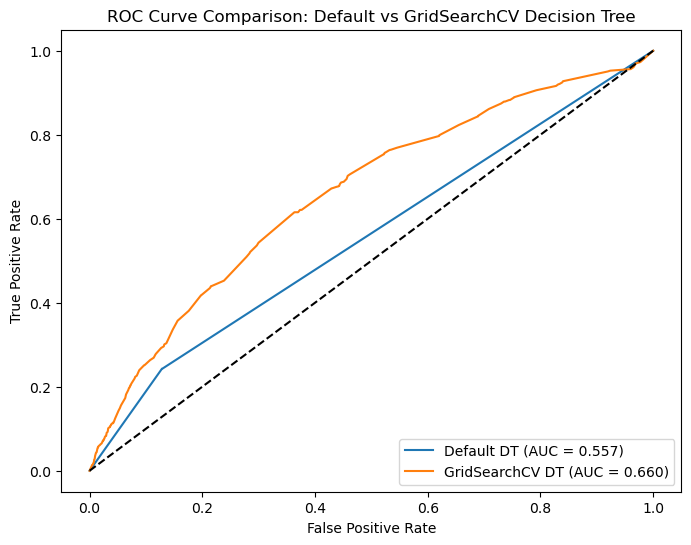

In [19]:
#3
from sklearn.metrics import roc_curve, roc_auc_score
# Probabilities for ROC curve
y_test_proba_default = dt_pipeline.predict_proba(X_test)[:, 1]
y_test_proba_grid = best_dt_model.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUC
fpr_default, tpr_default, _ = roc_curve(y_test, y_test_proba_default)
auc_default = roc_auc_score(y_test, y_test_proba_default)

fpr_grid, tpr_grid, _ = roc_curve(y_test, y_test_proba_grid)
auc_grid = roc_auc_score(y_test, y_test_proba_grid)

print(f"Default DT AUC: {auc_default:.4f}")
print(f"GridSearchCV DT AUC: {auc_grid:.4f}")

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_default, tpr_default, label=f"Default DT (AUC = {auc_default:.3f})")
plt.plot(fpr_grid, tpr_grid, label=f"GridSearchCV DT (AUC = {auc_grid:.3f})")
plt.plot([0,1], [0,1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Default vs GridSearchCV Decision Tree")
plt.legend(loc="lower right")
plt.show()


In [20]:
#4
# Get the classifier and preprocessor from the tuned pipeline
tree_model_best = best_dt_model.named_steps['classifier']
preprocessor_best = best_dt_model.named_steps['preprocessor']

# Get feature names after preprocessing
try:
    feature_names = preprocessor_best.get_feature_names_out()
except Exception:
    num_names = preprocessor_best.transformers_[0][2]
    cat_enc   = preprocessor_best.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(cat_enc.get_feature_names_out(preprocessor_best.transformers_[1][2]))
    feature_names = np.array(num_names + cat_names)

# Get top 10 most important features
importances = tree_model_best.feature_importances_
feature_importances = pd.Series(importances, index=feature_names)
top_features = feature_importances.nlargest(10)

print("Top features that contribute to predicting 'kicks':")
print(top_features)


Top features that contribute to predicting 'kicks':
VehBCost                            0.133919
VehYear                             0.113611
PurchaseTimestamp                   0.078293
VehOdo                              0.076172
MMRCurrentRetailRatio               0.061159
WheelType_Alloy                     0.053961
MMRAcquisitionAuctionCleanPrice     0.044608
MMRAcquisitionRetailAveragePrice    0.039302
WarrantyCost                        0.038935
MMRAcquisitonRetailCleanPrice       0.030299
dtype: float64


## Task 3

In [21]:
# Reuse from Task 1: preprocess, X_train, X_test, y_train, y_test
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Fixed `RANDOM_STATE` for repeatable results.
RANDOM_STATE = 42

In [22]:
# Reusing Task-1 preprocessing in a single end-to-end pipeline
pipe_full = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameter tuning: regularisation type & strength
# L1/L2 regularisations control sparsity vs ridge-style shrinkage
# Liblinear/saga support L1
param_grid_full = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_full = GridSearchCV(pipe_full, param_grid_full, cv=5, scoring="accuracy", n_jobs=-1)
grid_full.fit(X_train, y_train)

# Predictions
ytr_pred_full = grid_full.predict(X_train)
yte_pred_full = grid_full.predict(X_test)

print("Best params:", grid_full.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_full))
print("Test  acc:", accuracy_score(y_test, yte_pred_full))
print("\nConfusion matrix:\n", confusion_matrix(y_test, yte_pred_full))
print("\nReport:\n", classification_report(y_test, yte_pred_full))

# Top 5 features
best_full = grid_full.best_estimator_
feat_names = best_full.named_steps["prep"].get_feature_names_out()
coefs = best_full.named_steps["clf"].coef_[0]
top5 = pd.DataFrame({"Feature": feat_names, "Coef": coefs, "Abs": np.abs(coefs)}).sort_values("Abs", ascending=False).head(5)
display(top5)

# Using predicted probabilities to compute ROC/AUC
yprob_full = best_full.predict_proba(X_test)[:,1]
fpr_full, tpr_full, _ = roc_curve(y_test, yprob_full)
auc_full = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, label=f"Full (AUC={auc_full:.3f})")

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Train acc: 0.8707655213984328
Test  acc: 0.8706605593056895

Confusion matrix:
 [[7221    1]
 [1072    2]]

Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.67      0.00      0.00      1074

    accuracy                           0.87      8296
   macro avg       0.77      0.50      0.47      8296
weighted avg       0.84      0.87      0.81      8296



,Feature,Coef,Abs
13,VehBCost,-0.311732,0.311732
1,VehYear,-0.309670,0.309670
8,MMRCurrentAuctionAveragePrice,0.270037,0.270037
11,MMRCurrentRetailCleanPrice,-0.268263,0.268263
129,WheelType_Covers,-0.261478,0.261478


Best params (RFE): {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'rfe__n_features_to_select': 80}
Train acc: 0.8706449668474985
Test  acc: 0.8707810993249759


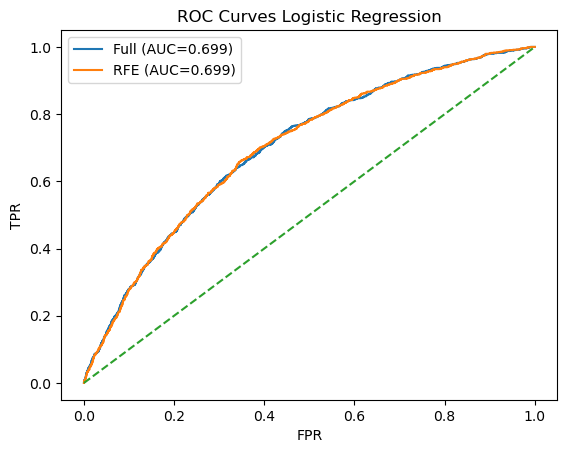

Overfitting gap (Full): 0.00010496209274324375
Overfitting gap (RFE): -0.0001361324774774575


In [23]:
# Base estimator is used by RFE to score feature usefulness
base_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver="liblinear", penalty="l2")

pipe_rfe = Pipeline([
    ("prep", preprocess),
    ("rfe", RFE(base_lr, n_features_to_select=50, step=0.1)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameters to tune:
# How many features RFE should keep
# Logistic penalty type & regularisation strength (C)
# Compatible solvers
param_grid_rfe = {
    "rfe__n_features_to_select": [30, 50, 80],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_rfe = GridSearchCV(pipe_rfe, param_grid_rfe, cv=5, scoring="accuracy", n_jobs=-1)
grid_rfe.fit(X_train, y_train)

# Predictions
ytr_pred_rfe = grid_rfe.predict(X_train)
yte_pred_rfe = grid_rfe.predict(X_test)

print("Best params (RFE):", grid_rfe.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_rfe))
print("Test  acc:", accuracy_score(y_test, yte_pred_rfe))

# Plotting the ROC curve
best_rfe = grid_rfe.best_estimator_
yprob_rfe = best_rfe.predict_proba(X_test)[:,1]
fpr_rfe, tpr_rfe, _ = roc_curve(y_test, yprob_rfe)
auc_rfe = auc(fpr_rfe, tpr_rfe)
plt.plot(fpr_rfe, tpr_rfe, label=f"RFE (AUC={auc_rfe:.3f})")

# Plotting the diagonal reference and finalising the ROC figure
plt.plot([0,1],[0,1],"--")
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves Logistic Regression"); plt.show()

# Checking overfitting (comparing train vs test accuracy gaps)
gap_full = accuracy_score(y_train, ytr_pred_full) - accuracy_score(y_test, yte_pred_full)
gap_rfe  = accuracy_score(y_train, ytr_pred_rfe) - accuracy_score(y_test, yte_pred_rfe)
print("Overfitting gap (Full):", gap_full)
print("Overfitting gap (RFE):", gap_rfe)

In [24]:
# Selecting the better model by test accuracy
# If RFE model tests are atleast as good as the Full model, we will prefer RFE for simplicity
use_rfe = accuracy_score(y_test, yte_pred_rfe) >= accuracy_score(y_test, yte_pred_full)
chosen = best_rfe if use_rfe else best_full
model_name = "RFE" if use_rfe else "Full"

# Getting the post processing feature names, if RFE is better we keep a subset
feat_names_all = chosen.named_steps["prep"].get_feature_names_out()
if "rfe" in chosen.named_steps:
    mask = chosen.named_steps["rfe"].support_
    feat_names = feat_names_all[mask]
else:
    feat_names = feat_names_all

# Coefficients from the final LR
coefs = chosen.named_steps["clf"].coef_.ravel()
print(f"{model_name} features: {len(feat_names)}, coefficients: {len(coefs)}")

coef_df = (pd.DataFrame({"Feature": feat_names, "Coef": coefs})
             .assign(Abs=lambda d: d["Coef"].abs())
             .sort_values("Abs", ascending=False))
top10 = coef_df.head(10)

print("Top contributors from", model_name)
display(top10)

# Positive coef means higher odds of IsBadBuy=1, negative coef means lower odds
print("Positive coef -> higher odds of IsBadBuy=1 (likely kick); Negative -> lower odds.")
print("Note: one-hot effects are relative to the baseline category.")

RFE features: 80, coefficients: 80
Top contributors from RFE


,Feature,Coef,Abs
78,WheelType_Covers,-0.523426,0.523426
44,PRIMEUNIT_NO,-0.429324,0.429324
14,Auction_MANHEIM,-0.371071,0.371071
12,AUCGUART_GREEN,-0.350971,0.350971
11,VehBCost,-0.347416,0.347416
1,VehYear,-0.330539,0.330539
6,MMRCurrentAuctionAveragePrice,0.271296,0.271296
9,MMRCurrentRetailCleanPrice,-0.267489,0.267489
55,TopThreeAmericanName_GM,-0.262314,0.262314
43,Nationality_AMERICAN,-0.237329,0.237329


Positive coef -> higher odds of IsBadBuy=1 (likely kick); Negative -> lower odds.
Note: one-hot effects are relative to the baseline category.


## Task 4

In [25]:
# === Task 4 BOOTSTRAP
import os, glob, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Defaults
if "RANDOM_STATE" not in globals(): RANDOM_STATE = 42
if "TARGET_COL"   not in globals(): TARGET_COL   = "IsBadBuy"

# 1) Load df if missing
def _find_csv():
    for p in ["data/kick.csv", "kick.csv", "assignment 1 data kick.csv"]:
        if os.path.isfile(p): return p
    for p in glob.glob("**/*.csv", recursive=True):
        if "kick" in os.path.basename(p).lower(): return p
    return None

if "df" not in globals():
    path = _find_csv()
    if not path:
        raise FileNotFoundError("kick.csv not found. Put it in ./data/ or next to the notebook.")
    # Avoid dtype fragmentation warnings
    df = pd.read_csv(path, low_memory=False)
    # Turn '?' into NaN
    df.replace("?", np.nan, inplace=True)
    # Promote numeric-like object columns to numeric (simple heuristic)
    for c in df.columns:
        if c == TARGET_COL:
            continue
        if df[c].dtype == "object":
            s = pd.to_numeric(df[c], errors="coerce")
            if s.notna().mean() > 0.6:  # majority numeric -> treat as numeric
                df[c] = s

# 2) Train/test split if missing
if not all(v in globals() for v in ["X_train","X_test","y_train","y_test"]):
    drop_cols = [c for c in ["PurchaseID","PurchaseDate"] if c in df.columns]
    y = df[TARGET_COL]
    X = df.drop(columns=[TARGET_COL] + drop_cols)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

# 3) Preprocess pipeline (categorical forced to string AFTER impute)
if "preprocess" not in globals():
    num_feat = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_feat = X_train.columns.difference(num_feat).tolist()

    numeric = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("to_str", FunctionTransformer(lambda X: X.astype(object).astype(str))),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocess = ColumnTransformer(
        [("num", numeric, num_feat),
         ("cat", categorical, cat_feat)],
        remainder="drop",
        verbose_feature_names_out=False
    )

# 4) Fit preprocess ONCE and grid-search DT on the preprocessed matrix (no OneHot inside the grid)
if "dt_best" not in globals():
    # Fit preprocessor on train and transform to numeric matrix
    prep_fitted = preprocess.fit(X_train, y_train)
    Xtr = prep_fitted.transform(X_train)
    # Ensure dense
    if hasattr(Xtr, "toarray"): Xtr = Xtr.toarray()

    # Now search a Decision Tree directly on Xtr (pure numeric) -> avoids mixed-type encoder issues
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
    grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 7, None],
        "min_samples_split": [2, 10, 50],
        "min_samples_leaf": [1, 5, 25],
    }
    dt_search = GridSearchCV(dt, grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    dt_search.fit(Xtr, y_train)
    best_dt = dt_search.best_estimator_

    # Rebuild a Pipeline so that downstream code can use dt_best.named_steps["prep"]/["clf"]
    dt_best = Pipeline([("prep", prep_fitted), ("clf", best_dt)])
    print("[Task4 bootstrap] Fitted preprocess and tuned DecisionTree on preprocessed matrix.")
else:
    print("[Task4 bootstrap] Using existing dt_best / preprocess / split.")


[Task4 bootstrap] Fitted preprocess and tuned DecisionTree on preprocessed matrix.


**Task 4.1 — Additional processing for NN**

- Numeric features are **standardized** (zero-mean / unit-variance) via `StandardScaler`.
- Categorical features are **one-hot encoded** with `OneHotEncoder(handle_unknown="ignore")`.
- Missing values are handled by `SimpleImputer` (median for numeric, most_frequent for categorical).
- These steps are already defined in our `preprocess` from Task 1 and applied *consistently* to train/test to avoid leakage.
- Standardization is **important for NN** to stabilize gradients and speed up convergence.


NN baseline (full) | Train acc=0.873  Test acc=0.871  Test AUC=0.708


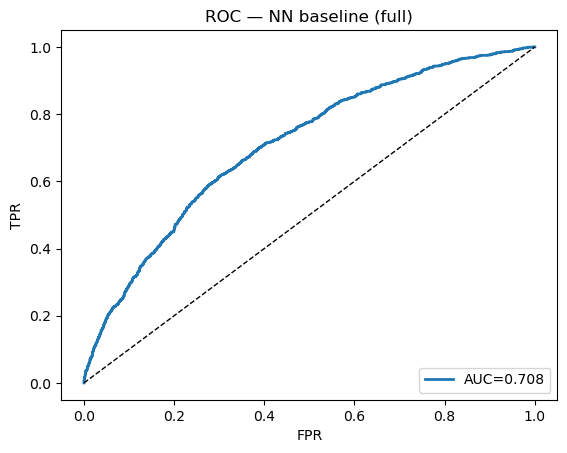

Best params (NN full): {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 128, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001, 'max_iter': 300}
NN tuned (full) | Train acc=0.872  Test acc=0.871  Test AUC=0.708


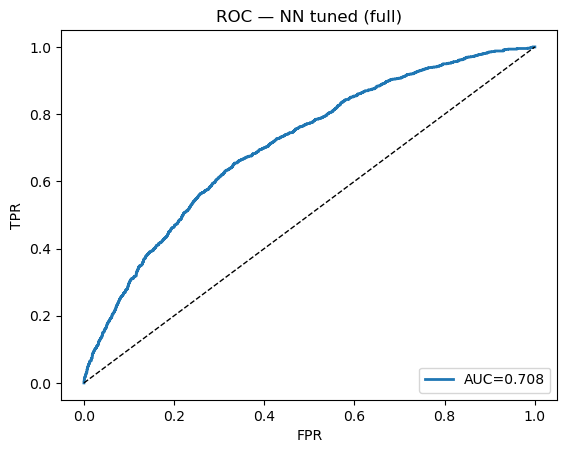

Converged iters: 19  (max_iter=300, early_stopping=True)
Overfitting gap (train - test acc): 0.001


In [26]:
# Task 4.2 — NN with full feature set (simple GridSearch)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report

# --- A) Build preprocessed matrices (use the already-fitted DT pipeline's preprocessor if available) ---
# This keeps one-hot columns consistent with Task 2.
if 'dt_best' in globals():
    prep_for_nn = dt_best.named_steps['prep']
else:
    # fallback: fit our preprocess on training data (still simple)
    prep_for_nn = preprocess.fit(X_train, y_train)

Xtr = prep_for_nn.transform(X_train)
Xte = prep_for_nn.transform(X_test)

# Safety: ensure dense arrays for scikit-learn MLP
if hasattr(Xtr, "toarray"): Xtr = Xtr.toarray()
if hasattr(Xte, "toarray"): Xte = Xte.toarray()

# --- helper functions (simple) ---
def nn_scores(model, name=""):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    acc_tr  = accuracy_score(y_train, yhat_tr)
    acc_te  = accuracy_score(y_test,  yhat_te)
    proba_te = model.predict_proba(Xte)[:,1] if hasattr(model, "predict_proba") else model.decision_function(Xte)
    auc_te = roc_auc_score(y_test, proba_te)
    print(f"{name} | Train acc={acc_tr:.3f}  Test acc={acc_te:.3f}  Test AUC={auc_te:.3f}")
    return acc_tr, acc_te, auc_te

def plot_roc_simple(model, title):
    proba_te = model.predict_proba(Xte)[:,1] if hasattr(model, "predict_proba") else model.decision_function(Xte)
    fpr, tpr, _ = roc_curve(y_test, proba_te)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title)
    plt.legend(loc="lower right"); plt.show()
    return roc_auc

# --- B) Baseline NN (for reference) ---
nn_base = MLPClassifier(
    hidden_layer_sizes=(64,), activation="relu", solver="adam",
    max_iter=300, early_stopping=True, random_state=RANDOM_STATE
)
nn_base.fit(Xtr, y_train)
_ = nn_scores(nn_base, "NN baseline (full)")
_ = plot_roc_simple(nn_base, "ROC — NN baseline (full)")

# --- C) Tuned NN via simple GridSearch (keep it small & student-like) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
nn_gs = GridSearchCV(
    estimator=MLPClassifier(random_state=RANDOM_STATE, early_stopping=True, solver="adam"),
    param_grid={
        "hidden_layer_sizes": [(64,), (128,), (64,32)],
        "activation": ["relu", "tanh"],
        "alpha": [1e-4, 1e-3],                # L2
        "learning_rate_init": [1e-3, 3e-3],   # step size
        "batch_size": [128, 256],
        "max_iter": [300]
    },
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True
)
nn_gs.fit(Xtr, y_train)
nn_full = nn_gs.best_estimator_

print("Best params (NN full):", nn_gs.best_params_)
acc_tr_full, acc_te_full, auc_te_full = nn_scores(nn_full, "NN tuned (full)")
auc_full_curve = plot_roc_simple(nn_full, "ROC — NN tuned (full)")

# Convergence / overfitting notes for the report
print(f"Converged iters: {nn_full.n_iter_}  (max_iter={nn_full.max_iter}, early_stopping={nn_full.early_stopping})")
print(f"Overfitting gap (train - test acc): {acc_tr_full - acc_te_full:.3f}")


In [27]:
# Task 4.3 — NN on reduced feature set selected by best Decision Tree
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# 0) Safety: make sure we have dt_best, matrices Xtr/Xte
if 'dt_best' not in globals():
    raise RuntimeError("dt_best not found. Please run the Task 4 bootstrap cell first.")
prep_dt = dt_best.named_steps["prep"]
dt_clf  = dt_best.named_steps["clf"]

# If the matrices from 4.2 are missing, build them now
if 'prep_for_nn' not in globals():
    prep_for_nn = prep_dt
if 'Xtr' not in globals() or 'Xte' not in globals():
    Xtr = prep_for_nn.transform(X_train)
    Xte = prep_for_nn.transform(X_test)
    if hasattr(Xtr, "toarray"): Xtr = Xtr.toarray()
    if hasattr(Xte, "toarray"): Xte = Xte.toarray()

# 1) Build robust feature names (avoid calling prep_dt.get_feature_names_out())
#    - numeric names = original numeric columns
#    - categorical names = OHE.get_feature_names_out(cat_original_cols)
num_cols, cat_cols = [], []
for name, trans, cols in prep_dt.transformers_:
    if name == "num":
        num_cols = list(cols)
    elif name == "cat":
        cat_cols = list(cols)

ohe = prep_dt.named_transformers_["cat"].named_steps["onehot"]
cat_ohe_names = ohe.get_feature_names_out(cat_cols)
feat_names = np.array(list(num_cols) + list(cat_ohe_names))

# 2) Use DT importances to pick top-K features
importances = dt_clf.feature_importances_
assert importances.shape[0] == feat_names.shape[0], \
    f"Length mismatch: importances={importances.shape[0]} vs names={feat_names.shape[0]}"

K = 25  # student-level choice; adjust if needed
top_idx = np.argsort(importances)[::-1][:K]
top_feats = feat_names[top_idx]

# 3) Slice reduced matrices
Xtr_red = Xtr[:, top_idx]
Xte_red = Xte[:, top_idx]

print(f"Reduced inputs = {K}")
print("Sample selected features:", list(top_feats[:10]), "...")

# 4) Simple GridSearch for NN on reduced set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
nn_red_gs = GridSearchCV(
    estimator=MLPClassifier(random_state=RANDOM_STATE, early_stopping=True, solver="adam"),
    param_grid={
        "hidden_layer_sizes": [(64,), (64,32)],
        "activation": ["relu", "tanh"],
        "alpha": [1e-4, 1e-3],
        "learning_rate_init": [1e-3, 3e-3],
        "batch_size": [64, 128],
        "max_iter": [300]
    },
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True
)
nn_red_gs.fit(Xtr_red, y_train)
nn_red = nn_red_gs.best_estimator_

# 5) Metrics for the report
yhat_tr = nn_red.predict(Xtr_red)
yhat_te = nn_red.predict(Xte_red)
acc_tr_red = accuracy_score(y_train, yhat_tr)
acc_te_red = accuracy_score(y_test,  yhat_te)
proba_te_red = nn_red.predict_proba(Xte_red)[:,1]
auc_te_red = roc_auc_score(y_test, proba_te_red)

print("Best params (NN reduced):", nn_red_gs.best_params_)
print(f"NN tuned (reduced) | Train acc={acc_tr_red:.3f}  Test acc={acc_te_red:.3f}  Test AUC={auc_te_red:.3f}")
print(f"Converged iters (reduced): {nn_red.n_iter_}  (max_iter={nn_red.max_iter}, early_stopping={nn_red.early_stopping})")
print(f"Overfitting gap (reduced; train - test acc): {acc_tr_red - acc_te_red:.3f}")


Reduced inputs = 25
Sample selected features: ['VehYear', 'VehBCost', 'WheelTypeID', 'Auction_MANHEIM', 'WheelType_Covers', 'WarrantyCost', 'WheelType_Alloy', 'MMRCurrentRetailRatio', 'VehOdo', 'PurchaseTimestamp'] ...
Best params (NN reduced): {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.003, 'max_iter': 300}
NN tuned (reduced) | Train acc=0.877  Test acc=0.871  Test AUC=0.721
Converged iters (reduced): 28  (max_iter=300, early_stopping=True)
Overfitting gap (reduced; train - test acc): 0.005


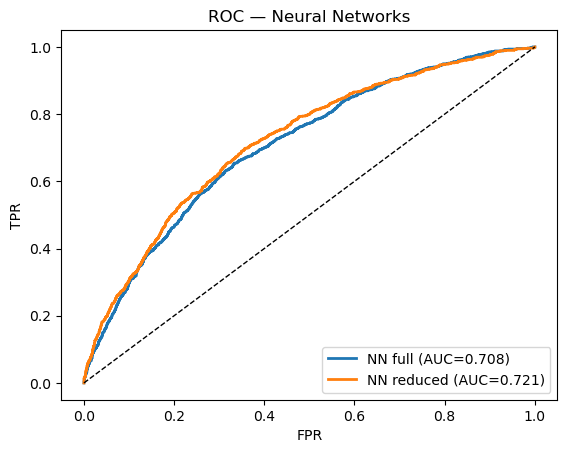


=== REPORT SNIPPETS ===
(i) Full NN best params: {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 128, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001, 'max_iter': 300}
(ii) Full NN: Train acc=0.872, Test acc=0.871, Test AUC=0.708, n_iter=19, early_stopping=True
(iii) Reduced NN best params: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.003, 'max_iter': 300}
(iv) Reduced NN: Train acc=0.877, Test acc=0.871, Test AUC=0.721, n_iter=28, early_stopping=True
(v) Selected inputs (top-25 by DT): ['VehYear', 'VehBCost', 'WheelTypeID', 'Auction_MANHEIM', 'WheelType_Covers', 'WarrantyCost', 'WheelType_Alloy', 'MMRCurrentRetailRatio', 'VehOdo', 'PurchaseTimestamp', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRCurrentAuctionCleanPrice'] ...
(vi) Which is better? Reduced model has higher AUC.
Interpretation: NN is not ea

In [28]:
# Task 4.4 — ROC curves (full vs reduced)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier

# --- 0) Ensure we have preprocessor and split ---
if 'dt_best' not in globals():
    raise RuntimeError("dt_best is missing. Run the Task 4 bootstrap cell first.")
prep_for_nn = dt_best.named_steps['prep']

# Build Xtr/Xte if missing
if 'Xtr' not in globals() or 'Xte' not in globals():
    Xtr = prep_for_nn.transform(X_train)
    Xte = prep_for_nn.transform(X_test)
    if hasattr(Xtr, "toarray"): Xtr = Xtr.toarray()
    if hasattr(Xte, "toarray"): Xte = Xte.toarray()

# --- 1) Ensure nn_full exists (fallbacks if needed) ---
if 'nn_full' not in globals():
    if 'nn_gs' in globals():
        nn_full = nn_gs.best_estimator_
    else:
        # simple fallback baseline
        nn_full = MLPClassifier(hidden_layer_sizes=(64,), activation="relu",
                                solver="adam", max_iter=300, early_stopping=True,
                                random_state=RANDOM_STATE)
        nn_full.fit(Xtr, y_train)

# --- 2) Ensure reduced inputs & nn_red exist (rebuild if needed) ---
need_red_matrix = ('Xtr_red' not in globals()) or ('Xte_red' not in globals()) or ('top_idx' not in globals())
need_nn_red     = ('nn_red' not in globals())

if need_red_matrix or need_nn_red:
    # Recompute reduced feature indices from dt_best (using OHE names)
    prep_dt = dt_best.named_steps["prep"]
    dt_clf  = dt_best.named_steps["clf"]

    # numeric + cat original cols
    num_cols, cat_cols = [], []
    for name, trans, cols in prep_dt.transformers_:
        if name == "num":
            num_cols = list(cols)
        elif name == "cat":
            cat_cols = list(cols)

    ohe = prep_dt.named_transformers_["cat"].named_steps["onehot"]
    cat_ohe_names = ohe.get_feature_names_out(cat_cols)
    feat_names = np.array(list(num_cols) + list(cat_ohe_names))

    importances = dt_clf.feature_importances_
    assert importances.shape[0] == feat_names.shape[0], \
        f"Length mismatch: importances={importances.shape[0]} vs names={feat_names.shape[0]}"

    if 'K' not in globals():
        K = 25  # same K as in 4.3
    top_idx = np.argsort(importances)[::-1][:K]
    top_feats = feat_names[top_idx]

    # Build reduced matrices
    Xtr_red = Xtr[:, top_idx]
    Xte_red = Xte[:, top_idx]

if need_nn_red:
    if 'nn_red_gs' in globals():
        nn_red = nn_red_gs.best_estimator_
    else:
        # simple fallback: small NN on reduced set
        nn_red = MLPClassifier(hidden_layer_sizes=(64,), activation="relu",
                               solver="adam", max_iter=300, early_stopping=True,
                               random_state=RANDOM_STATE)
        nn_red.fit(Xtr_red, y_train)

# --- 3) Plot ROC for both models ---
p_full = nn_full.predict_proba(Xte)[:,1] if hasattr(nn_full, "predict_proba") else nn_full.decision_function(Xte)
p_red  = nn_red.predict_proba(Xte_red)[:,1] if hasattr(nn_red, "predict_proba") else nn_red.decision_function(Xte_red)

fpr_f, tpr_f, _ = roc_curve(y_test, p_full)
fpr_r, tpr_r, _ = roc_curve(y_test, p_red)
auc_f = auc(fpr_f, tpr_f); auc_r = auc(fpr_r, tpr_r)

plt.figure()
plt.plot(fpr_f, tpr_f, lw=2, label=f"NN full (AUC={auc_f:.3f})")
plt.plot(fpr_r, tpr_r, lw=2, label=f"NN reduced (AUC={auc_r:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Neural Networks")
plt.legend(loc="lower right"); plt.show()

# --- 4) Print quick metrics & report snippets ---
from sklearn.metrics import accuracy_score

yhat_tr_full = nn_full.predict(Xtr);    yhat_te_full = nn_full.predict(Xte)
yhat_tr_red  = nn_red.predict(Xtr_red); yhat_te_red  = nn_red.predict(Xte_red)

acc_tr_full = accuracy_score(y_train, yhat_tr_full)
acc_te_full = accuracy_score(y_test,  yhat_te_full)
acc_tr_red  = accuracy_score(y_train, yhat_tr_red)
acc_te_red  = accuracy_score(y_test,  yhat_te_red)

print("\n=== REPORT SNIPPETS ===")
if 'nn_gs' in globals():
    print(f"(i) Full NN best params: {nn_gs.best_params_}")
else:
    print("(i) Full NN best params: (fallback baseline used)")
print(f"(ii) Full NN: Train acc={acc_tr_full:.3f}, Test acc={acc_te_full:.3f}, Test AUC={auc_f:.3f}, "
      f"n_iter={getattr(nn_full,'n_iter_', 'NA')}, early_stopping={getattr(nn_full,'early_stopping','NA')}")
if 'nn_red_gs' in globals():
    print(f"(iii) Reduced NN best params: {nn_red_gs.best_params_}")
else:
    print("(iii) Reduced NN best params: (fallback baseline used)")
print(f"(iv) Reduced NN: Train acc={acc_tr_red:.3f}, Test acc={acc_te_red:.3f}, Test AUC={auc_r:.3f}, "
      f"n_iter={getattr(nn_red,'n_iter_', 'NA')}, early_stopping={getattr(nn_red,'early_stopping','NA')}")
print(f"(v) Selected inputs (top-{len(top_idx)} by DT):", list(top_feats[:15]), "...")
print(f"(vi) Which is better? {'Reduced' if auc_r>auc_f else 'Full'} model has higher AUC.")
print("Interpretation: NN is not easily interpretable; we use DT-selected inputs as a proxy to describe 'kick' tendencies.")
